Copied from 2017-08-17

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
import json
import subprocess
import cv2
import glob
%matplotlib inline

In [3]:
from opmap.VideoData import VideoData
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie
from opmap.cmap import bipolar

# hj map & Ina map & pvmap

In [5]:
wf_width = 10
size_h = 200
size_w = 400

data_dirs = [
    '/mnt/recordings/SimulationResults/20170823-5',
]



In [6]:
#for data_dir in data_dirs:
data_dir = data_dirs[0]
    
print data_dir

save_dir = data_dir.replace( 
    '/SimulationResults/',
    '/AnalysisResult/Seno/simulation/Mahajan/20170824/'
)
if not os.path.exists(save_dir): os.makedirs(save_dir)

length = len( glob.glob(data_dir+ '/vmem*.npy') )
#length = 100

vm_array = np.zeros((length, size_h, size_w)) 
hj_array = np.zeros((length, size_h, size_w))
m_array = np.zeros((length, size_h, size_w))
Ina = np.zeros((length, size_h, size_w))
for i in range(length):
    num = '{0:04d}'.format(i)
    a = np.load(  os.path.join( data_dir, 'cell_%s/%s' % (num, 'h.npy')) )
    b = np.load(  os.path.join( data_dir, 'cell_%s/%s' % (num, 'j.npy')) )
    hj_array[i, :, :] = a*b
    vm_array[i, :, :] = np.load( os.path.join( data_dir, 'vmem_%s.npy' % (num)) )
    #m_array[i, :, :] = np.load( os.path.join( data_dir, 'cell_%s/%s' % (num, 'm.npy')) )
    Ina[i, :, :] = np.load( os.path.join( data_dir, 'cell_%s/%s' % (num, 'xina.npy')) )

vmem = VideoData(length, size_h, size_w)
vmem.data = np.copy(vm_array)
vmem.cmap = bipolar(neutral=0, lutsize=1024)
vmem.vmin = np.min(vmem.data)
vmem.vmax = np.max(vmem.data)
pmap = PhaseMap(vmem, shrink=1)

/mnt/recordings/SimulationResults/20170823-5


In [ ]:
pvmap = PhaseVarianceMap(pmap, size=5)

x = np.arange(size_w)
y = np.arange(size_h)
X, Y = np.meshgrid(x, y)

#d = os.path.join(save_dir, 'vmem'); vmem.saveImage(d); makeMovie(d); os.rmdir(d)
#d = os.path.join(save_dir, 'pvmap'); pvmap.saveImage(d); makeMovie(d); os.rmdir(d)

d = os.path.join(save_dir, 'contour')
if not os.path.exists(d): os.makedirs(d)

for i in range(length):
    if i < wf_width+1:
        continue

    plt.clf()

    plt.subplot(2,2,1)
    vmem.showFrame(i)
    
    plt.subplot(2,2,2)
    im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8) 
    im_out[:, :, 1] = (np.sum((Ina[i-wf_width:i, :, :] < -1), axis=0) > 0) * 255
    im_out[:, :, 2] = (np.sum((Ina[i-wf_width:i, :, :] < -1), axis=0) > 0) * 255
    im_out = 255 - im_out
    plt.imshow(im_out)
    v = plt.axis()
    Z = hj_array[i,:,:]
    plt.contour(X, Y, Z)
    plt.axis(v)
    
    plt.subplot(2,2,3)
    pmap.showFrame(i)

    plt.subplot(2,2,4)
    pvmap.showFrame(i)

    plt.gca().set_aspect('equal')    
    plt.savefig(os.path.join(d, '{0:0>6}.png'.format(i-wf_width-1)))    

subprocess.call(
    'ffmpeg -r 30 -y -i "{0}" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}"'.format(
        os.path.join(d, '%06d.png'),
        os.path.join(save_dir, 'contour.mp4'),
    ),
    shell=True
)

## Zoom up

In [7]:
pvmap = PhaseVarianceMap(pmap, size=3)
wf_width = 1

In [14]:
off_x = 200
off_y = 75
size_w = 60
size_h = 60
f_start = 750
f_end = 810

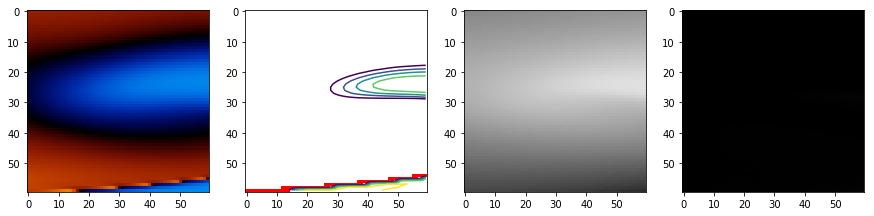

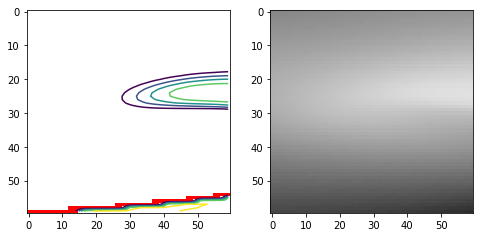

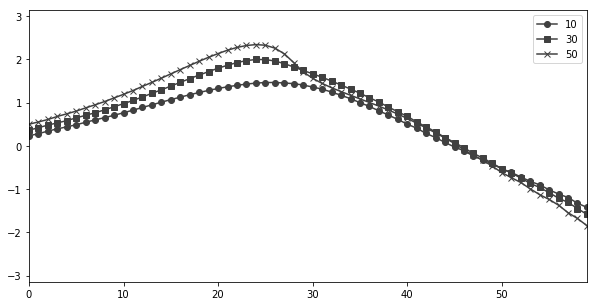

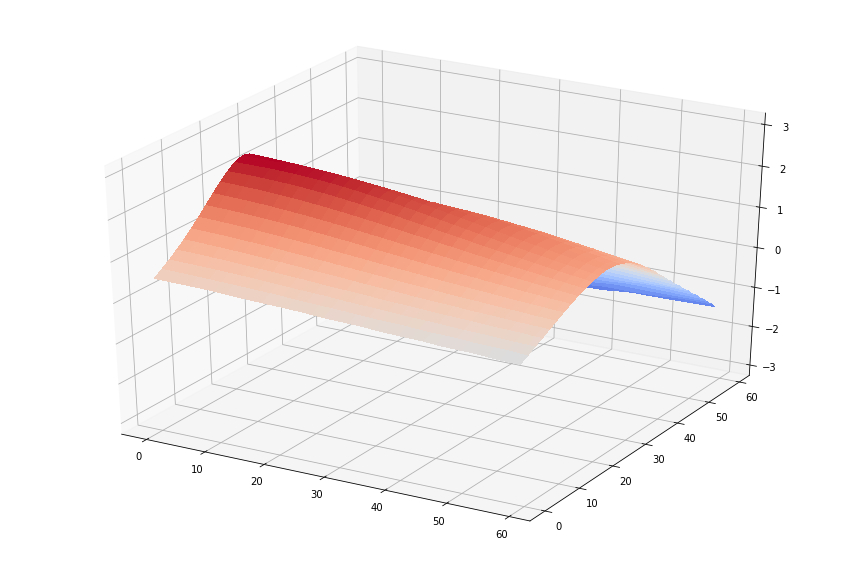

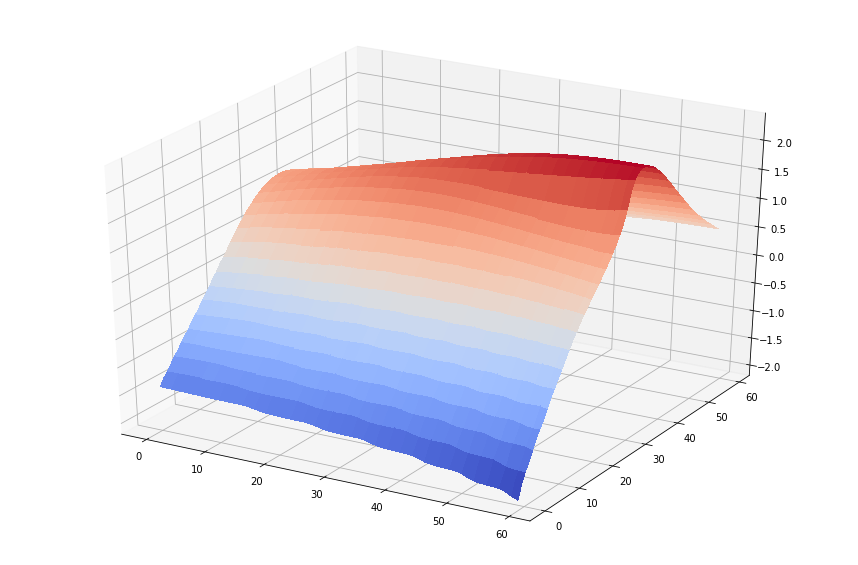

In [17]:
dirs = {}
keys = [
    'surface_top', 
    'surface_bottom', 
    'plot',
    'zoom_row',
    'zoom_pair'
]
for key in keys:
    d = os.path.join(save_dir, key)
    dirs[key] = d
    if not os.path.exists(d): os.makedirs(d)

y = np.arange(size_h)
x = np.arange(size_w)
X, Y = np.meshgrid(x, y)    

vmem_min = np.min(vmem.data)
vmem_max=np.max(vmem.data)

for f in range(f_start, f_end):
    plt.close("all")
    Z =np.copy( pmap.data[f-3,off_y:off_y+size_h,off_x:off_x+size_w] )

    if True:
        fig = plt.figure(figsize=(15,5))
        #fig = plt.figure()

        #plt.subplot(1,3,1)
        #pmap.showFrame(f)

        plt.subplot(1,4,1)
        plt.imshow(
            vmem.data[f,off_y:off_y+size_h,off_x:off_x+size_w],
            cmap=bipolar(neutral=0, lutsize=1024), vmin=vmem_min, vmax=vmem_max,
            interpolation='nearest'
        )

        plt.subplot(1,4,2)
        im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8) 
        im_out[:, :, 1] = (np.sum((Ina[f-wf_width:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
        im_out[:, :, 2] = (np.sum((Ina[f-wf_width:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
        im_out = 255 - im_out
        plt.imshow(im_out)
        v = plt.axis()
        HJ = hj_array[f,off_y:off_y+size_h,off_x:off_x+size_w]
        plt.contour(X, Y, HJ)
        plt.axis(v)

        plt.subplot(1,4,3)
        plt.imshow(
            Z, 
            cmap='gray', vmin=-np.pi, vmax=np.pi,
            interpolation='nearest'
        )

        plt.subplot(1,4,4)
        plt.imshow(
            pvmap.data[f-3,off_y:off_y+size_h,off_x:off_x+size_w],
            cmap='gray', vmin=0, vmax=1,
            interpolation='nearest'
        )

        plt.savefig(
            os.path.join(dirs['zoom_row'], "{0:0>4}.png".format(f)),
            bbox_inches='tight'
        )
        
    if True:
        fig = plt.figure(figsize=(8,5))
        #fig = plt.figure()

        #plt.subplot(1,3,1)
        #pmap.showFrame(f)

        plt.subplot(1,2,1)
        im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8) 
        im_out[:, :, 1] = (np.sum((Ina[f-1:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
        im_out[:, :, 2] = (np.sum((Ina[f-1:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
        im_out = 255 - im_out
        plt.imshow(im_out)
        v = plt.axis()
        HJ = hj_array[f,off_y:off_y+size_h,off_x:off_x+size_w]
        plt.contour(X, Y, HJ)
        plt.axis(v)

        plt.subplot(1,2,2)
        #Z[:20, :] = Z[20, :]
        plt.imshow(
            Z, 
            cmap='gray', vmin=-np.pi, vmax=np.pi,
            interpolation='nearest'
        )
        
        plt.savefig(
            os.path.join(dirs['zoom_pair'], "{0:0>4}.png".format(f)),
            bbox_inches='tight'
        )
    
    if True:
        fig = plt.figure(figsize=(10,5))
        markers = 'osxD^v+<>p'
        for i, pos_x in enumerate(np.arange(10, size_w, 20)): 
        #for pos_x in np.array([40, 50]): 
            plt.plot(
                Z[:,pos_x], 
                label='{0}'.format(pos_x),
                marker=markers[i],
                color = '192',
                #antialiased=False
            )
        plt.ylim([-np.pi, np.pi])
        plt.xlim([0, size_h-1])
        plt.legend()
        #plt.gca().set_aspect('equal')    
        #plt.show()

        plt.savefig(
            os.path.join(dirs['plot'], "{0:0>4}.png".format(f)),
            bbox_inches='tight'
        )

    if True:
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z[:,::-1], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
        ax.set_zlim([-np.pi, np.pi])
        plt.savefig(
            os.path.join(dirs['surface_top'], "{0:0>4}.png".format(f)),
            bbox_inches='tight'
        )
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z[::-1,:], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
        plt.savefig(
            os.path.join(dirs['surface_bottom'], "{0:0>4}.png".format(f)),
            bbox_inches='tight'
        )
        